# Degradation analysis of a PV system (Executable without Solar Data Tools)

This notebook is a short version using PVPRO to analyze the NIST dataset. The full version is in 'NIST_ground_array_analyze_detailed'.

It can be run without Solar Data Tools.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [1]:
import pandas as pd
import numpy as np
from pvlib.pvsystem import retrieve_sam
from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.plotting import plot_results_timeseries
from scipy.io import savemat
import matplotlib.pyplot as plt

/Users/baojie/opt/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (5.2.0)/charset_normalizer (3.3.2) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Load data

In [2]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/752151f8-7ba3-486e-954c-0126227f89b5/resource/e40a91f9-fa84-4a2b-b6d8-312c15fc761b/download/nist01_onemin-ground.pkl
sys_name = 'NIST_ground'
dfi = pd.read_pickle('examples/data/nist01_onemin-Ground.pkl')
df = dfi[::20]  # downsample to 20 min

In [3]:
# Meta information of PV module
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6
delta_T = 3
technology = 'mono-Si'
module = retrieve_sam('CECmod')['Sharp_NU_U235F2']

# Preprocess

In [4]:
pre = Preprocessor(df,
                   voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series,
                   ignore_warning=True
                   )

In [ ]:
# If solar-data-tool is installed, change 'use_sdt' to True
df_pro = pre.run_basic_preprocess(use_sdt = False)
df_pro['current_irradiance_outliers'], filter_IG_info = pre.find_current_irradiance_outliers(
                                                    df_pro, points_per_iteration=1000)
df_pro['voltage_temperature_outliers'], filter_VT_info= pre.find_temperature_voltage_outliers(df_pro, 
                                                  voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=1000) 

# Parameter extraction

In [6]:
pvp = PvProHandler(df=df_pro,
                  voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   system_name=sys_name,
                   technology=technology
                  )

In [7]:
boolean_mask = np.logical_and.reduce((
                                       np.logical_not(df_pro['current_irradiance_outliers']),
                                       np.logical_not(df_pro['clipped_times']),
                                       np.logical_not(df_pro['voltage_temperature_outliers']),
                                       df_pro[irradiance_poa_key]>100,
                                       np.logical_or.reduce((
                                            df_pro['operating_cls']==0,
                                            df_pro['operating_cls']==1,
                                            df_pro['operating_cls']==2
                                            ))
                                    ))

In [8]:
# Estimate initial parameters
pvp.estimate_p0(boolean_mask=boolean_mask, technology = technology)
pvp.p0['diode_factor'] = 1

In [9]:
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    'days_per_run': 14,
    'iterations_per_year': 26,
    'start_point_method': 'last',
    'saturation_current_multistart': [1],
    'verbose': False,
    'diode_factor': pvp.p0['diode_factor']
}

In [10]:
fit_params = ['photocurrent_ref', 'saturation_current_ref','resistance_series_ref', 
              'conductance_shunt_extra', 'resistance_shunt_ref', 'diode_factor']
lower_bounds = dict(
            diode_factor=0.1,
            photocurrent_ref=0.01,
            saturation_current_ref=5e-12,
            resistance_series_ref=0.1,
            conductance_shunt_extra=0,
            resistance_shunt_ref=100
        )

upper_bounds = dict(
    diode_factor=1.5,
    photocurrent_ref=10,
    saturation_current_ref=1e-6,
    resistance_series_ref=2,
    conductance_shunt_extra=0,
    resistance_shunt_ref=1000
)
ret = pvp.execute(iteration='all', fit_params= fit_params,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                  **hyperparams,
                  boolean_mask = boolean_mask,
                  technology=technology) 

  0%|          | 0/103 [00:00<?, ?it/s]

100%|██████████| 103/103 [00:04<00:00, 24.80it/s]

Elapsed time: 0.07 min


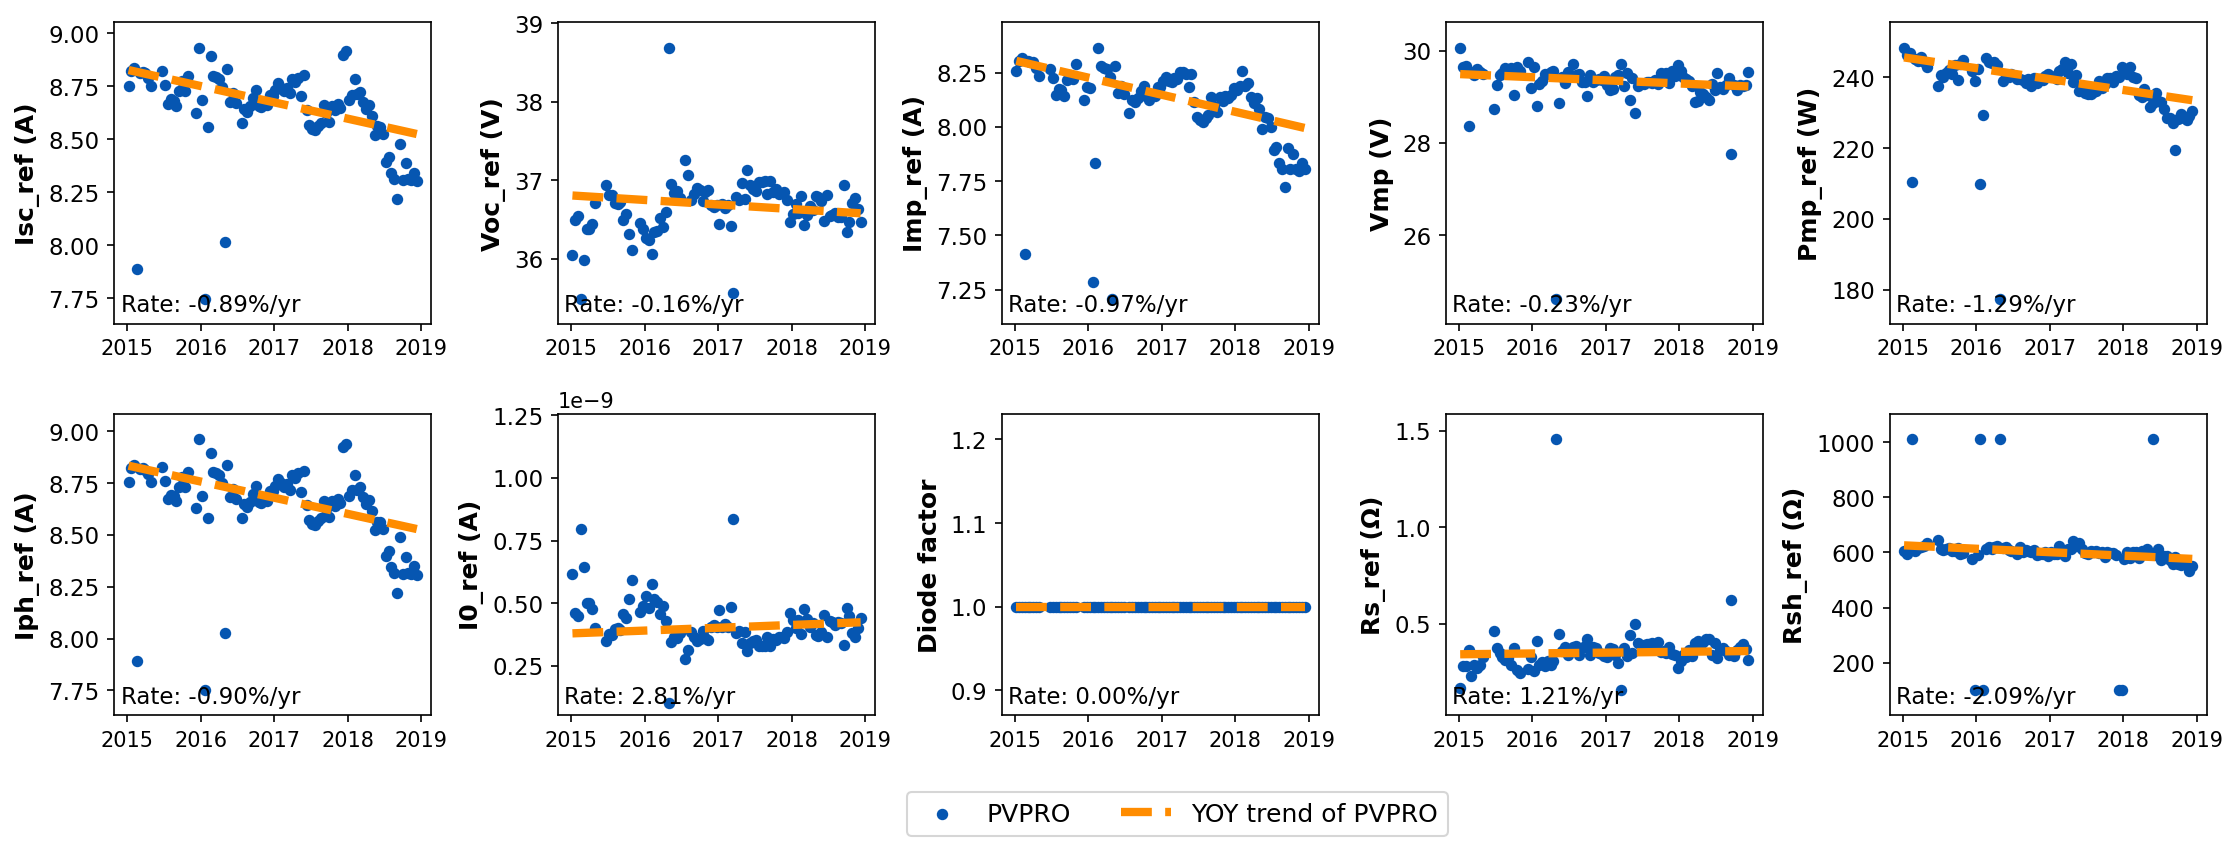

In [14]:
# Pull out fitting results
pfit = pvp.result['p']

# Calculate YOY trend
yoy_result = pvp.analyze_yoy(pfit)

# Plot the evolution of extracted parameters
plot_results_timeseries(pfit, 
                        yoy_result = yoy_result, 
                        yoy_plot = True, 
                        legendloc  = [-0.3,-0.4])